In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/.julia/dev/LaserFields/examples`


In [2]:
using PyPlot
using TextWrap
using FFTW
using YAML

In [3]:
using LaserFields
using LaserFields: GaussianLaserField, SinExpLaserField, LinearFlatTopLaserField, Linear2FlatTopLaserField, InterpolatingLaserField
using LaserFields: au_as

# Simple example of the `LaserField` constructor
For the accepted parameters and conventions, check the documentation of the Fortran [laserfields library](https://github.com/jfeist/laserfields).

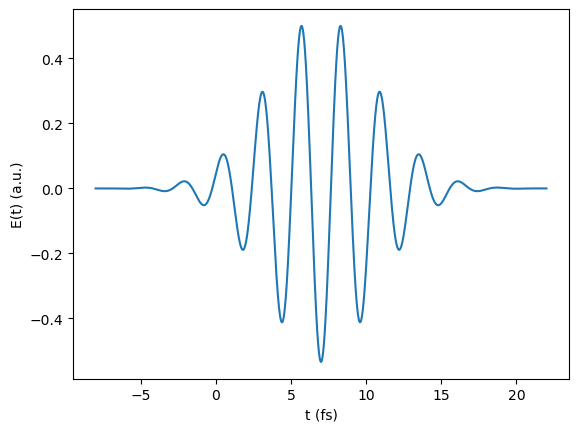

In [4]:
lf = LaserField(form="gaussianI", is_vecpot=true, duration_as=6000,
                lambda_nm=800, intensity_Wcm2=1e16, peak_time_as=7000.)
ts = LinRange(-8000,22000,2001)*au_as
plot(ts/au_as*1e-3,lf.(ts))
xlabel("t (fs)")
ylabel("E(t) (a.u.)");

In [5]:
general_args = (is_vecpot=true,E0=1.5,ω0=0.12,t0=500.,chirp=0.,ϕ0=0.8π)
test_fields = [
    GaussianLaserField(;      general_args...,σ=100.),
    SinExpLaserField(;        general_args...,T=800.,exponent=2),
    SinExpLaserField(;        general_args...,T=800.,exponent=4),
    SinExpLaserField(;        general_args...,T=800.,exponent=7),
    LinearFlatTopLaserField(; general_args...,Tflat=400.,Tramp=150),
    Linear2FlatTopLaserField(;general_args...,Tflat=400.,Tramp=150),
    InterpolatingLaserField("laserdat.dat", is_vecpot=true),
    InterpolatingLaserField("laserdat.dat", is_vecpot=false)
];

# Plot the envelopes and fields of the different pulse shapes

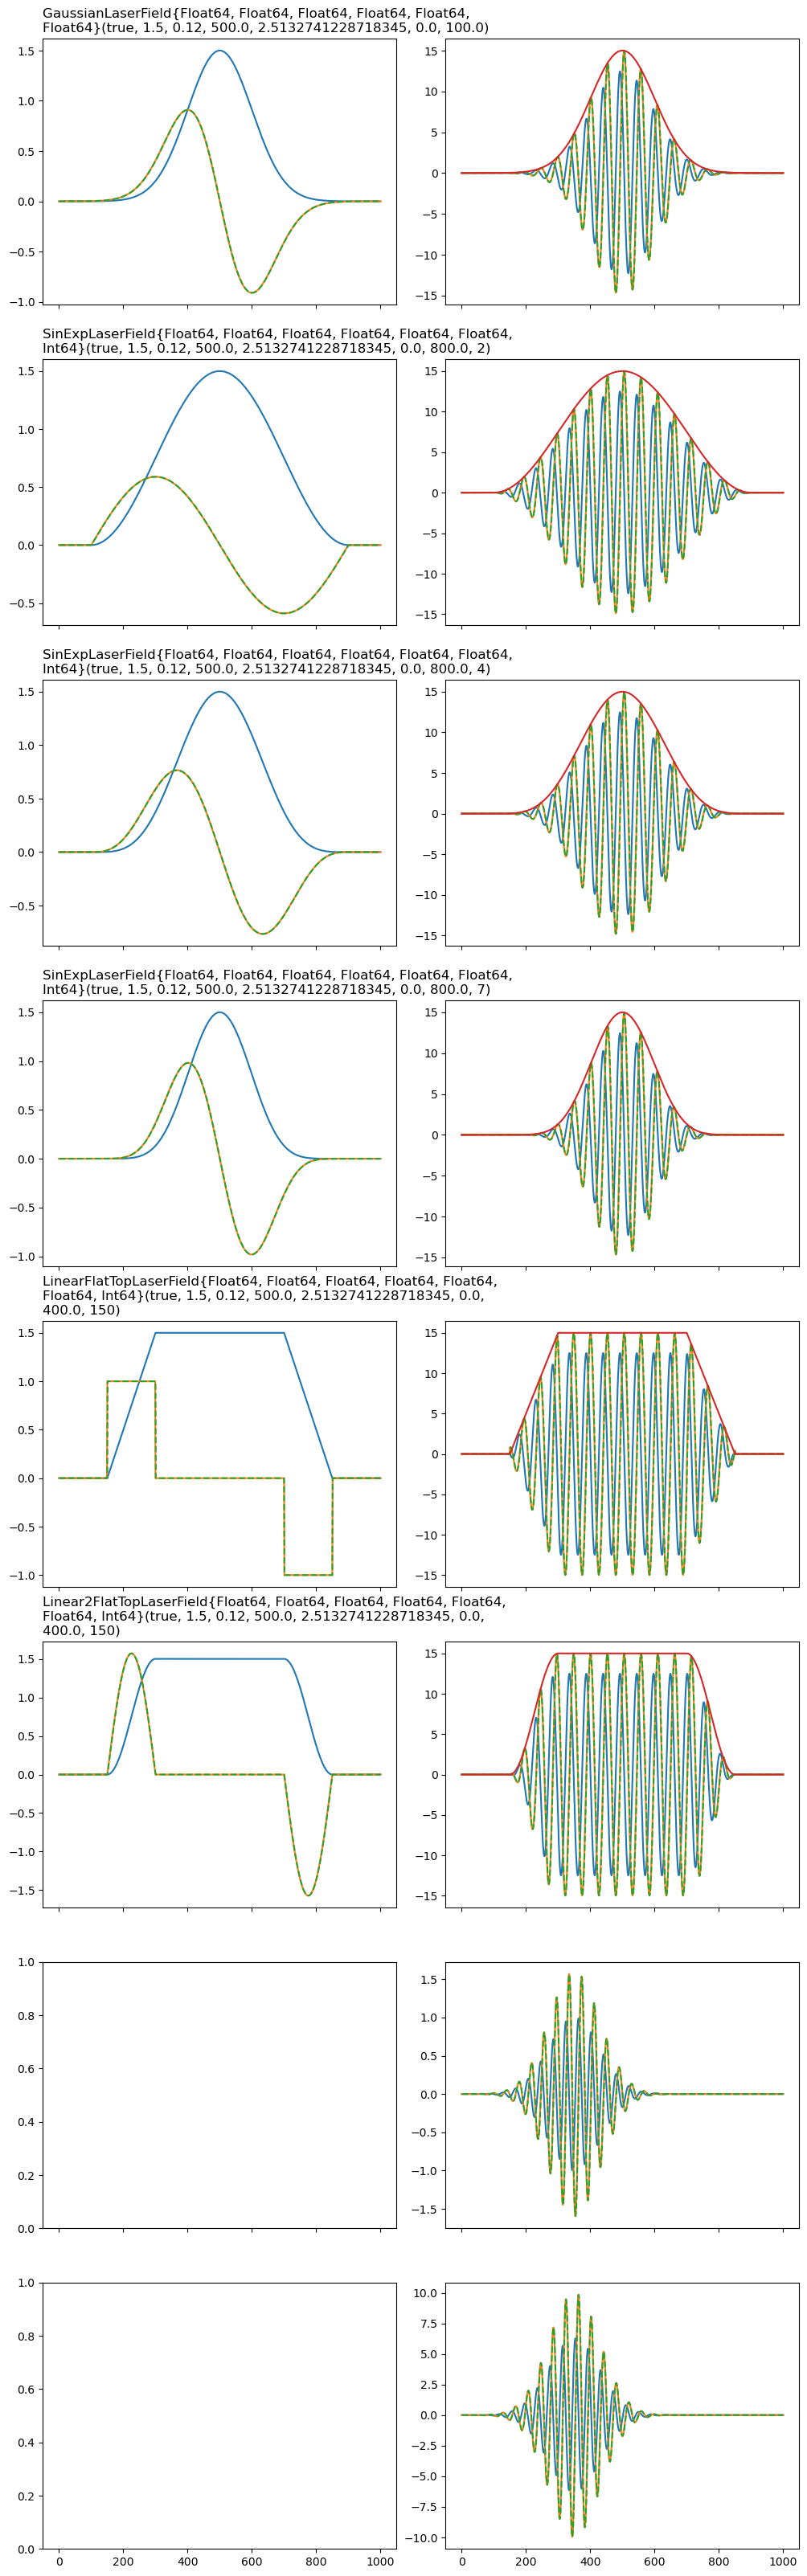

In [6]:
fig,axs = subplots(length(test_fields),2,figsize=(10,4*length(test_fields)),sharex=true)
ts = LinRange(0,1000,1001)
for (lf,ax) in zip(test_fields,eachrow(axs))
    try
        env, envpr = eachrow(reduce(hcat,map(collect,LaserFields._envelope.(lf,ts .- lf.t0))))
        ax[1].set_title(wrap(string(lf)),loc="left",fontsize=12)
        ax[1].plot(ts,env)
        ax[1].plot(ts,       100*envpr)
        ax[1].plot(ts[2:end],100*diff(env)./diff(ts),"--")
    catch
    end
    E = lf.(ts)
    A = A_field.(lf,ts)
    ax[2].plot(ts,A)
    ax[2].plot(ts,10*E)
    ax[2].plot(ts[2:end],10*-diff(A)./diff(ts),"--")
    try
        ax[2].plot(ts,10*envelope.(lf,ts))
    catch
    end
end
fig.tight_layout(pad=0.5)

# Compare the analytical Fourier transforms with numerical ones

In [7]:
function can_fourier(lf)
    try
        E_fourier(lf,1.)
        return true
    catch
        return false
    end
end
test_fields_fourier = filter(can_fourier,test_fields);

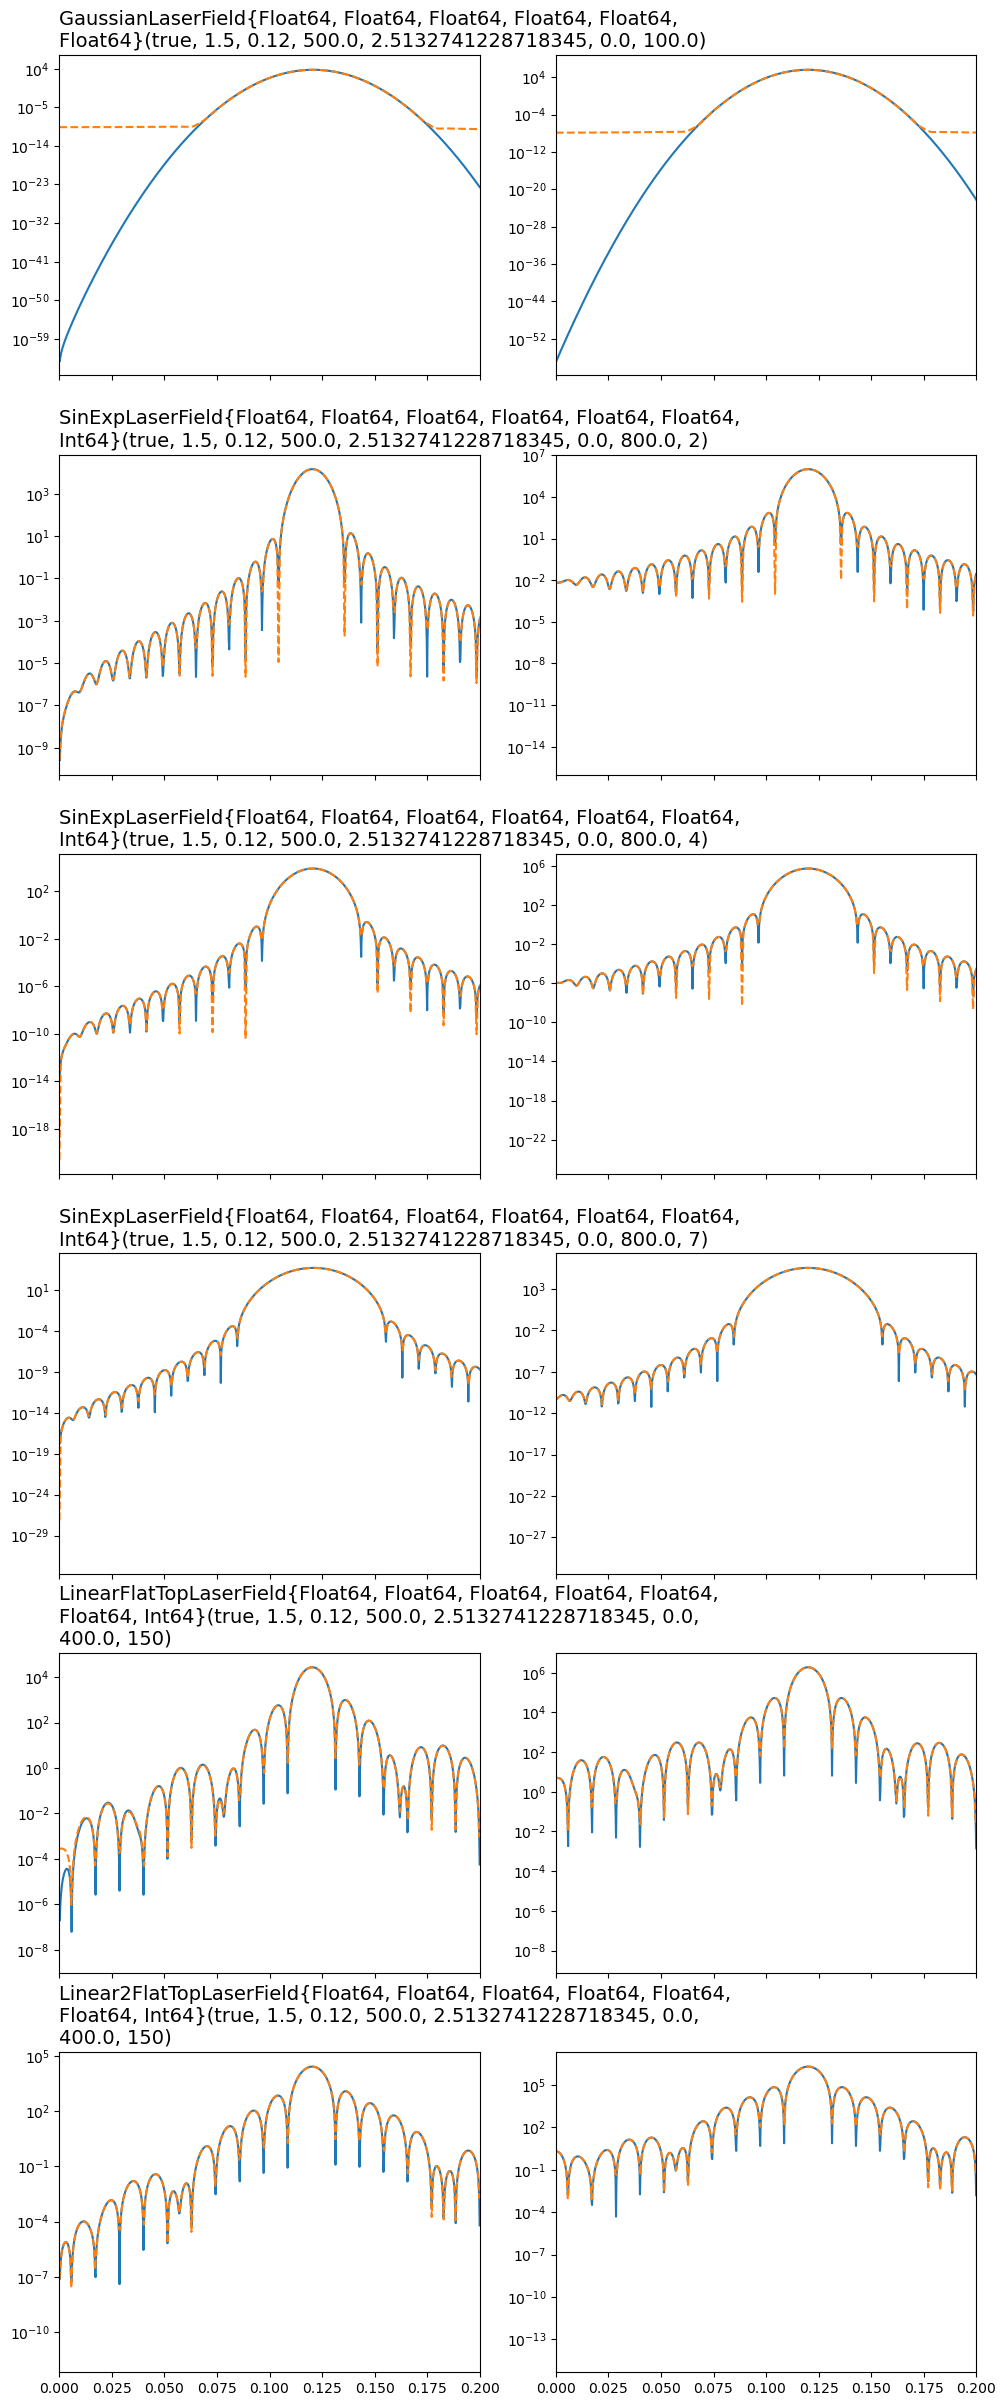

In [8]:
fig,axs = plt.subplots(length(test_fields_fourier),2,figsize=(10,4*length(test_fields_fourier)),sharex=true)
ts = LinRange(0,10000,10001)
ωs = LinRange(0,0.2,1001)[2:end]
for (lf,ax) in zip(test_fields,eachrow(axs))
    EF = E_fourier.(lf,ωs)
    AF = A_fourier.(lf,ωs)
    E = E_field.(lf,ts)
    A = A_field.(lf,ts)
    ωs2 = 2π*fftshift(fftfreq(length(ts),inv(ts[2]-ts[1])))
    fftfac = sqrt((ts[2]-ts[1])/2π)
    EF2 = fftfac * fftshift(fft(E))
    AF2 = fftfac * fftshift(fft(A))
    ax[1].set_title(wrap(string(lf)),loc="left",fontsize=14)
    ax[1].plot(ωs,abs2.(EF))
    ax[1].plot(ωs2,abs2.(EF2),"--")
    ax[2].plot(ωs,abs2.(AF))
    ax[2].plot(ωs2,abs2.(AF2),"--")
    ax[1].set_yscale("log")
    ax[2].set_yscale("log")
end
axs[1,1].set_xlim(0,0.2)
fig.tight_layout(pad=0.5)

# Show a chirped pulse

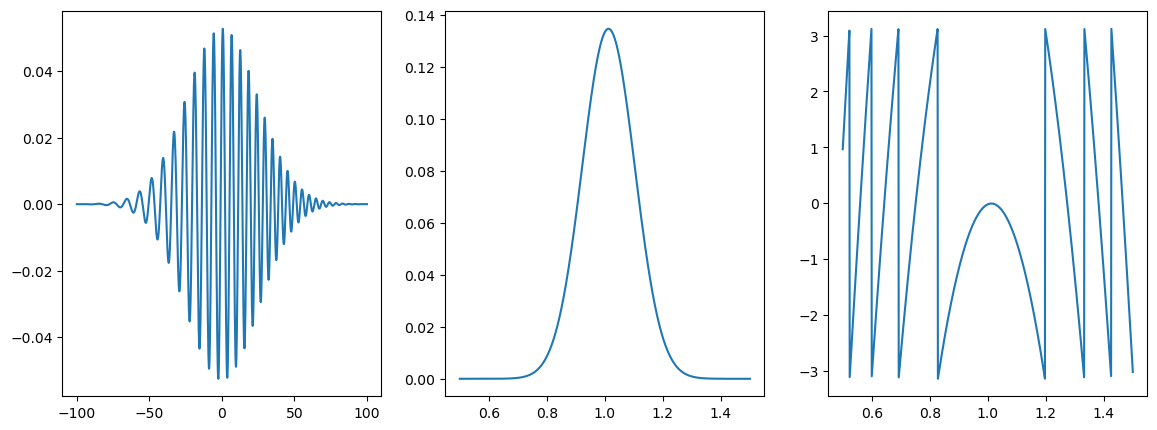

In [9]:
lf = LaserField(form="gaussianI",is_vecpot=true,intensity_Wcm2=1e14,lambda_nm=45.,
                peak_time_as=0,duration_as=1000.,ϕ0=0.3π,linear_chirp_rate_w0as=1e-4)
ts = LinRange(-100,100,2001)
fig, axs = subplots(1,3,figsize=(14,5))
axs[1].plot(ts,A_field.(lf,ts));
ωs = LinRange(0.5,1.5,1001)
axs[2].plot(ωs,abs2.(A_fourier.(lf,ωs)))
axs[3].plot(ωs,angle.(A_fourier.(lf,ωs)));

# Example of using a YAML configuration file to define the laser fields

In [10]:
open("test.yaml","w") do f
    print(f,"""
laser_fields:
- form: gaussianI
  is_vecpot: true
  intensity_Wcm2: 1e14
  duration_as: 700.
  peak_time_as: 2000.
  lambda_nm: 50.
  phase_pi: -0.5
  linear_chirp_rate_w0as: 3e-4
- form: linear2
  is_vecpot: true
  intensity_Wcm2: 2e14
  duration_as: 2000.
  rampon_as: 500
  peak_time_as: 1700.
  lambda_nm: 30.
  phase_pi: 0
  linear_chirp_rate_w0as: 0
""")
end

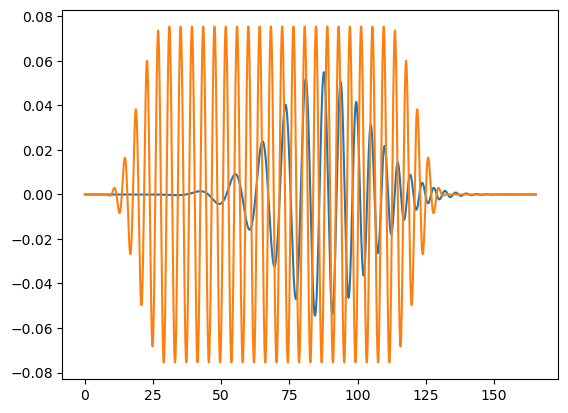

In [11]:
s = YAML.load_file("test.yaml"; dicttype=Dict{Symbol,Any});
lfs = LaserField.(s[:laser_fields])
ts = LinRange(0,4000*LaserFields.au_as,4001)

for lf in lfs
    plot(ts,lf.(ts))
end